# LSTM mean time samples based Progressive Rock and Others genres music classification

Single song is split into multiple pieces of consecutive 1200 time samples corresponding to top 13 mfcc feature. The 1200 time samples are compressed to 200 taking mean of consecutive time sample values. Number of pieces of songs is dependent on hop_length and sampling frequency. The label for each genrated piece is same as the original song. Song is assigned label corresponding to maximum occuring label on each piece.

## Importing Libraries.

In [0]:
# feature extractoring and preprocessing data
import librosa
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import os
from PIL import Image
import pathlib
import csv

# Preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from keras.models import load_model
from keras import models
from keras import layers
from keras.layers.recurrent import LSTM
from keras.layers import Bidirectional

from keras.layers.convolutional import Convolution2D
from keras.layers.convolutional import MaxPooling2D, ZeroPadding2D
from keras.layers.normalization import BatchNormalization
from sklearn.metrics import confusion_matrix
from keras.layers.advanced_activations import ELU
#Keras
import keras

import warnings
warnings.filterwarnings('ignore')
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


## User Parameters
**folders**: Name of the folders in path which contains differnet genres of songs.   
**hop_length**: number of audio samples between successive frames  
**numberofRowForMean**:  
**timeseries_length**:   
**songsPath**: Folder location where all the songs are present  
**savePath**: Folder location where generated feature will be saved  
**XFeatureFileName**: File name for the generated Input features for training  
**YFeatureFileName**: File name for the Labels corresponding to inputs for training  
**modelName**:  File name to save the trained model  
**pathToFeatures**:  Folder location where all the features are present  
**X_ValidationFeatureName**:  File name for the generated Input features from validation set  
**Y_ValidationFeatureName**:  File name for the Labels corresponding to input features from validation set  


In [0]:
folders = 'Progressive Rock Songs;Other Songs;Additional Pop Songs;Top Of The Pops'.split(';')

hop_length = 512
numberofRowForMean = 6
timeseries_length = 200 * numberofRowForMean
songsPath = f'/content/gdrive/My Drive/ML test/'
savePath = f'/content/gdrive/My Drive/My test/'
XFeatureFileName = "X_LSTM_Avg_Train.npy"
YFeatureFileName = "Y_LSTM_Avg_Train.npy"
modelName = 'LSTM_Model_Avg_60.h5'

pathToFeatures = savePath
X_ValidationFeatureName = 'X_LSTM_Avg_Validation.npy'
Y_ValidationFeatureName = 'Y_LSTM_Avg_Validation.npy'

## Feature Generation

In [0]:
list_of_audiofiles = []
label = []
timeseries_length_list = []
for g in folders:
  for filename in os.listdir(songsPath + g):
    songname = songsPath + g + '/' + filename
    list_of_audiofiles.append(songname)
    folderName = g.replace(" ","")
    if(folderName != "Prog"):
      label.append(0)  # Non Prog Rock
    else:
      label.append(1)  # Prog Rock
print(len(list_of_audiofiles))      


In [0]:
def extract_audio_features(list_of_audiofiles):
        data = [] 
        target = []
        count = 0 
        for i, file in enumerate(list_of_audiofiles):
            print(i , file)
            y, sr = librosa.load(file)            
            mfcc = librosa.feature.mfcc(y=y, sr=sr, hop_length=hop_length, n_mfcc=13)
            print(mfcc.T.shape)
            for samplesInt in range(0, mfcc.T.shape[0], timeseries_length):
              if samplesInt + timeseries_length < mfcc.T.shape[0]:
                avg_data = np.ones((200,13))
                row_index = 0
                mean_row = np.zeros((1,13))
                for j in range(samplesInt,samplesInt+timeseries_length):
                    mean_row += mfcc.T[j]
                    if((j+1)%(numberofRowForMean) == 0):
                       avg_data[row_index] = mean_row/numberofRowForMean
                       row_index +=1
                data.append(avg_data)
                
                count += 1
        X = np.asarray(data)
        return X, np.expand_dims(np.asarray(target), axis=1)

X,Y = extract_audio_features(list_of_audiofiles)
# Uncomment below lines of code to save feature set.
# with open( savePath + XFeatureFileName, 'wb') as f:
#   np.save(f, X)
# with open( savePath + YFeatureFileName, 'wb') as f:
#   np.save(f, Y)

## Model Training

In [0]:
X = np.load(pathToFeatures + XFeatureFileName)
Y = np.load(pathToFeatures + YFeatureFileName)
print(X.shape, Y.shape)
X_train = X
y_train = Y

(4281, 200, 13) (4281, 1)


Compiling ...
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_7 (LSTM)                (None, 200, 128)          72704     
_________________________________________________________________
bidirectional_4 (Bidirection (None, 64)                41216     
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 65        
Total params: 113,985
Trainable params: 113,985
Non-trainable params: 0
_________________________________________________________________
Epoch 1/60
4281/4281 [==============================] - 72s 17ms/step - loss: 0.6438 - acc: 0.6433
Epoch 2/60
4281/4281 [==============================] - 66s 15ms/step - loss: 0.6303 - acc: 0.6557
Epoch 3/60
4281/4281 [==============================] - 65s 15ms/step - loss: 0.6284 - acc: 0.6484
Epoch 4/60
4281/4281 [==============================] - 66s 15ms/step - loss: 0.6227 - ac

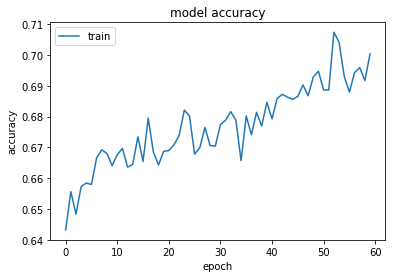

In [0]:
model = models.Sequential()

model.add(LSTM(units=128, dropout=0.05, recurrent_dropout=0.35, return_sequences=True,input_shape=(X_train.shape[1], X_train.shape[2]))) 
model.add(Bidirectional(LSTM(units=32, dropout=0.05, recurrent_dropout=0.35, return_sequences=False)))
model.add(layers.Dense(units=1, activation='sigmoid'))


print("Compiling ...")
model.compile(loss='binary_crossentropy', optimizer='Adam', metrics=['accuracy'])
model.summary()

history = model.fit(X_train,y_train, epochs = 60, batch_size=64)

model.save(pathToFeatures + modelName)

plt.plot(history.history['acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## Run model on Validation Set

In [0]:
X_val = np.load(pathToFeatures + X_ValidationFeatureName, allow_pickle=True)
y_val = np.load(pathToFeatures + Y_ValidationFeatureName, allow_pickle=True)
print(X_val.shape,y_val.shape)
y_val_fixed = []
labelIndex = 0
for i in range(0,X_val.shape[0]):  
  y_val_fixed.append(y_val[labelIndex])
  labelIndex += np.asarray(X_val[i]).shape[0]
  X_val[i] = np.asarray(X_val[i])
y_val_fixed = np.asarray(y_val_fixed)
print(y_val_fixed.shape)
print(np.array(X_val).shape)

(91,) (1351, 1)
(91, 1)
(91,)


In [0]:
model = load_model(pathToFeatures + modelName)

print(X_val.shape[0], y_val.shape)
predictionList = []
actualList = []
for i in range(0,X_val.shape[0]):
  predictions = model.predict(np.asarray(X_val[i]))
  y_pred = []
  for j in range(predictions.shape[0]):
    if(predictions[j] > 0.5):
      out = 1
    else:
      out = 0
    y_pred.append(out)
  
  count = np.count_nonzero(y_pred)
  if(count >= len(y_pred)*0.45):
    predictionList.append(1)
  else:
    predictionList.append(0)  
  print(int((count/len(y_pred))*100),count, len(y_pred), y_val_fixed[i][0], predictionList[i])
confusion_matrix(y_val_fixed,np.asarray(predictionList))
        


91 (1351, 1)
0 0 11 0 0
90 9 10 0 1
0 0 8 0 0
22 2 9 0 0
38 5 13 0 0
20 2 10 0 0
14 2 14 0 0
57 4 7 0 1
50 4 8 0 1
20 2 10 0 0
40 4 10 0 0
42 3 7 0 0
8 2 24 0 0
18 2 11 0 0
28 2 7 0 0
15 2 13 0 0
16 1 6 0 0
50 5 10 0 1
29 5 17 0 0
37 3 8 0 0
28 4 14 0 0
0 0 7 0 0
33 4 12 0 0
0 0 8 0 0
16 1 6 0 0
28 2 7 0 0
22 2 9 0 0
0 0 10 0 0
9 1 11 0 0
85 12 14 0 1
5 1 18 0 0
0 0 5 0 0
57 4 7 0 1
10 1 10 0 0
37 3 8 0 0
25 1 4 0 0
33 4 12 0 0
0 0 7 0 0
7 1 13 0 0
36 4 11 0 0
0 0 8 0 0
10 1 10 0 0
20 3 15 0 0
26 5 19 0 0
0 0 12 0 0
16 3 18 0 0
20 1 5 0 0
12 1 8 0 0
0 0 6 0 0
0 0 6 0 0
0 0 13 0 0
12 1 8 0 0
0 0 12 0 0
55 5 9 0 1
44 4 9 0 0
0 0 7 0 0
0 0 7 0 0
71 5 7 0 1
0 0 8 0 0
20 3 15 0 0
40 4 10 0 0
16 1 6 0 0
20 1 5 0 0
44 4 9 0 0
16 1 6 0 0
9 1 11 0 0
0 0 5 0 0
33 3 9 0 0
50 7 14 0 1
0 0 4 0 0
0 0 8 0 0
52 24 46 1 1
38 18 47 1 0
34 10 29 1 0
25 4 16 1 0
34 17 49 1 0
12 5 39 1 0
45 10 22 1 1
62 10 16 1 1
56 23 41 1 1
42 8 19 1 0
5 1 19 1 0
5 1 18 1 0
12 3 25 1 0
26 13 49 1 0
23 3 13 1 0
18 8 43 1 

array([[62,  9],
       [14,  6]])